# Desafío - Predicción de cancelación de reserva

Librerias

In [ ]:
!pip install scikeras

In [ ]:
!pip install --upgrade scikeras scikit-learn

In [ ]:
# 1. Importar librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# para crear la red neuronal
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import SGD
from scikeras.wrappers import KerasClassifier
from tensorflow.keras.layers import Dropout
from sklearn.model_selection import GridSearchCV

# para búsqueda de grilla
from sklearn.model_selection import GridSearchCV

# para procesamiento
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.model_selection import train_test_split

# para ignorar warnings
import warnings
warnings.filterwarnings('ignore')


Carda de datos

In [ ]:
# 2. Cargar el archivo
df = pd.read_csv('/content/hotel_bookings.csv')

# 3. Eliminar las columnas solicitadas
cols_to_drop = [
    'index',
    'arrival_date_year',
    'agent',
    'country',
    'company',
    'reservation_status',
    'reservation_status_date'
]

df.drop(columns=cols_to_drop, inplace=True, errors='ignore')  # en caso de no existir 'index' en el archivo

# 4. Revisar valores nulos
null_counts = df.isnull().sum()
total_rows = df.shape[0]

# mostrar el porcentaje de nulos
null_percent = (null_counts / total_rows) * 100
print("Porcentaje de valores nulos por columna:")
print(null_percent[null_percent > 0])

# 5. Decidir estrategia
if null_percent.sum() == 0:
    print("No hay valores nulos, seguimos sin problemas.")
else:
    # si el total de valores nulos es menor al 4% del total de registros, eliminamos filas con nulos
    total_missing = df.isnull().any(axis=1).sum()
    missing_percent = total_missing / total_rows * 100

    print(f"Total de registros con al menos un nulo: {total_missing} ({missing_percent:.2f}%)")

    if missing_percent < 4:
        df.dropna(inplace=True)
        print("Se eliminaron los registros con nulos porque representan menos del 4% del total.")
    else:
        # en caso mayor al 4% te muestro la estrategia que podríamos aplicar
        print("Hay más del 4% de registros con valores nulos. Te sugiero imputar los datos según el tipo de variable:")
        for col in df.columns:
            if df[col].isnull().sum() > 0:
                if df[col].dtype == 'object':
                    print(f"- Columna {col}: imputar con la moda (valor más frecuente).")
                    mode = df[col].mode()[0]
                    df[col].fillna(mode, inplace=True)
                else:
                    print(f"- Columna {col}: imputar con la mediana.")
                    median = df[col].median()
                    df[col].fillna(median, inplace=True)
        print("Datos faltantes imputados correctamente.")

# confirmar forma final del dataset
print("Shape final del dataframe:", df.shape)

Porcentaje de valores nulos por columna:
children    0.00335
dtype: float64
Total de registros con al menos un nulo: 4 (0.00%)
Se eliminaron los registros con nulos porque representan menos del 4% del total.
Shape final del dataframe: (119386, 26)


# Analisis Descriptivo

Variables Seleccionadas consideradas relevantes:

lead_time: mayor anticipación puede relacionarse con mayor probabilidad de
cancelación

previous_cancellations: historial de cancelaciones del cliente

deposit_type: si pagó/no pagó depósito influye

is_repeated_guest: clientes repetidos podrían cancelar menos
total_of_special_requests: clientes con peticiones especiales podrían cancelar menos

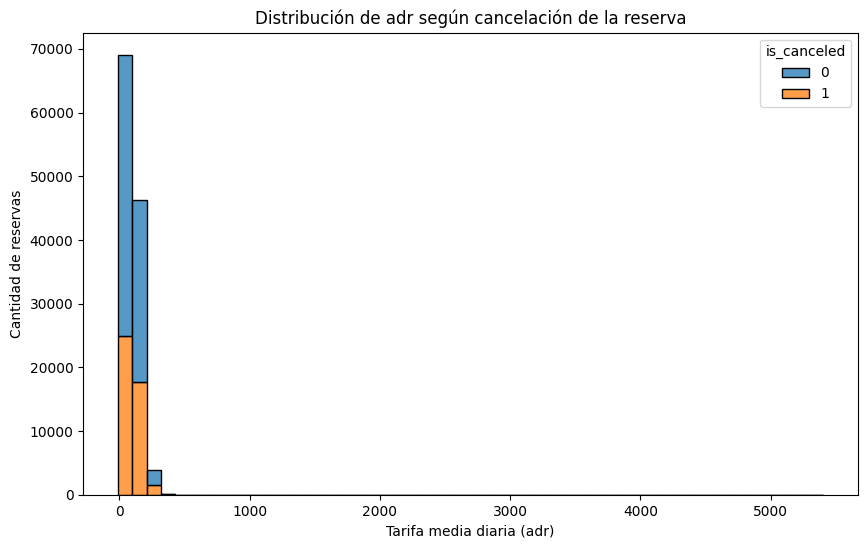

In [ ]:
# Histograma de adr por is_canceled
plt.figure(figsize=(10,6))
sns.histplot(data=df, x="adr", hue="is_canceled", bins=50, kde=False, multiple="stack")
plt.xlabel("Tarifa media diaria (adr)")
plt.ylabel("Cantidad de reservas")
plt.title("Distribución de adr según cancelación de la reserva")
plt.show()

Revisar outliers en adr

In [ ]:
# Revisar outliers usando el método IQR
Q1 = df['adr'].quantile(0.25)
Q3 = df['adr'].quantile(0.75)
IQR = Q3 - Q1

# límites
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# identificar outliers
outliers_low = df[df['adr'] < lower_bound]
outliers_high = df[df['adr'] > upper_bound]

print(f"Cantidad de outliers por abajo: {outliers_low.shape[0]}")
print(f"Cantidad de outliers por arriba: {outliers_high.shape[0]}")

# eliminar sólo los tres valores más extremos arriba y abajo
# para el resto imputamos con la media
adr_mean = df['adr'].mean()

# ordenar para encontrar los 3 más extremos
lowest_extremes = outliers_low.sort_values(by="adr").head(3).index
highest_extremes = outliers_high.sort_values(by="adr", ascending=False).head(3).index

# eliminamos estos tres extremos de cada lado
df.drop(index=lowest_extremes, inplace=True)
df.drop(index=highest_extremes, inplace=True)

# para el resto de outliers sustituimos por la media
df.loc[df['adr'] < lower_bound, 'adr'] = adr_mean
df.loc[df['adr'] > upper_bound, 'adr'] = adr_mean

print("Extremos más graves eliminados, el resto de outliers sustituidos por la media de adr.")

Cantidad de outliers por abajo: 0
Cantidad de outliers por arriba: 3793
Extremos más graves eliminados, el resto de outliers sustituidos por la media de adr.


Preparar dummies, estandarizar y split de entrenamiento/test

In [ ]:
# crear dummies
df_dummies = pd.get_dummies(df, drop_first=True)

# separar variables
X = df_dummies.drop("is_canceled", axis=1)
y = df_dummies["is_canceled"]

# estandarizar
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# división de datos
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.33, random_state=42, stratify=y
)

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)

X_train shape: (79986, 67)
X_test shape: (39397, 67)


# Implementa dos modelos de red neuronal multicapa

In [ ]:
# configuración inicialización
weight_init = "glorot_uniform"
bias_init = "zeros"

# --------------- Modelo 1 ----------------
model1 = Sequential([
    Dense(20, activation="tanh", kernel_initializer=weight_init, bias_initializer=bias_init, input_shape=(X_train.shape[1],)),
    Dense(20, activation="relu", kernel_initializer=weight_init, bias_initializer=bias_init),
    Dense(20, activation="tanh", kernel_initializer=weight_init, bias_initializer=bias_init),
    Dense(1, activation="sigmoid", kernel_initializer=weight_init, bias_initializer=bias_init)
])

# compilación
model1.compile(optimizer=SGD(), loss="binary_crossentropy", metrics=["accuracy"])

# entrenamiento
history1 = model1.fit(X_train, y_train, epochs=10, batch_size=32, verbose=1)

# --------------- Modelo 2 ----------------
model2 = Sequential([
    Dense(20, activation="tanh", kernel_initializer=weight_init, bias_initializer=bias_init, input_shape=(X_train.shape[1],)),
    Dense(20, activation="tanh", kernel_initializer=weight_init, bias_initializer=bias_init),
    Dense(20, activation="tanh", kernel_initializer=weight_init, bias_initializer=bias_init),
    Dense(1, activation="sigmoid", kernel_initializer=weight_init, bias_initializer=bias_init)
])

# compilación
model2.compile(optimizer=SGD(), loss="binary_crossentropy", metrics=["accuracy"])

# entrenamiento
history2 = model2.fit(X_train, y_train, epochs=10, batch_size=32, verbose=1)


Epoch 1/10
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.7173 - loss: 0.5609
Epoch 2/10
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - accuracy: 0.7956 - loss: 0.4330
Epoch 3/10
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - accuracy: 0.8056 - loss: 0.4131
Epoch 4/10
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.8130 - loss: 0.3998
Epoch 5/10
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8163 - loss: 0.3933
Epoch 6/10
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.8191 - loss: 0.3914
Epoch 7/10
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.8208 - loss: 0.3873
Epoch 8/10
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8174 - loss: 0.3884
Epoch 9/10
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8233 - loss: 0.3821
Epoch 10/10
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.8218 - loss: 0.3838
Epoch 1/10
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.7232 - loss: 0.5567
Epoch 2/10
2500/2500 ━━━━━━━

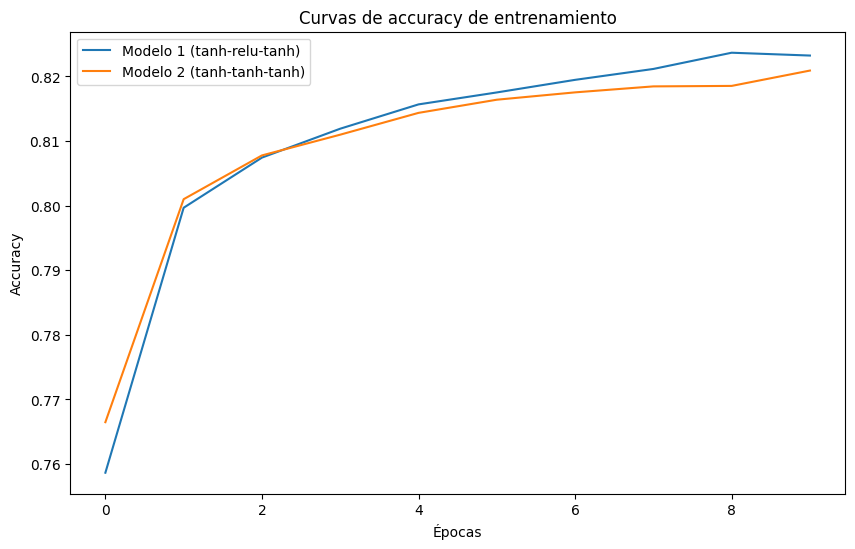

In [ ]:
# --------------- Graficar accuracies ----------------
plt.figure(figsize=(10,6))
plt.plot(history1.history['accuracy'], label='Modelo 1 (tanh-relu-tanh)')
plt.plot(history2.history['accuracy'], label='Modelo 2 (tanh-tanh-tanh)')
plt.xlabel("Épocas")
plt.ylabel("Accuracy")
plt.title("Curvas de accuracy de entrenamiento")
plt.legend()
plt.show()

Ambos modelos logran superar el umbral de 75% de accuracy propuesto, siendo el modelo con activación relu intermedia (Modelo 1) el que mostró mejor desempeño en términos de rapidez de convergencia y estabilidad de aprendizaje.

# Construye una red neuronal con regularización Dropout aplicando búsqueda de grilla para tres fold

Definiremos la función generadora de modelos para pasarla a la grilla:

In [ ]:
def build_model(hidden_layers=3,
                optimizer="adam",
                learning_rate=0.03,
                weight_init="glorot_uniform",
                dropout_rate=0.001):

    from tensorflow.keras.optimizers import SGD, Adam
    from tensorflow.keras import Sequential
    from tensorflow.keras.layers import Dense, Dropout

    if optimizer == "adam":
        opt = Adam(learning_rate=learning_rate)
    else:
        opt = SGD(learning_rate=learning_rate)

    model = Sequential()
    model.add(Dense(20, activation="tanh", kernel_initializer=weight_init, input_shape=(X_train.shape[1],)))
    model.add(Dropout(dropout_rate))

    for i in range(hidden_layers-1):
        model.add(Dense(20, activation="tanh", kernel_initializer=weight_init))
        model.add(Dropout(dropout_rate))

    model.add(Dense(1, activation="sigmoid"))

    model.compile(optimizer=opt, loss="binary_crossentropy", metrics=["accuracy"])

    return model

definir el grid de hiperparámetros

In [ ]:
# definimos el wrapper con los nombres correctos
keras_clf = KerasClassifier(
    model=build_model,
    epochs=10,
    batch_size=32,
    verbose=0
)

# grid de hiperparámetros usando el prefijo model__
param_grid = {
    "model__hidden_layers": [3, 4],
    "model__optimizer": ["adam", "sgd"],
    "model__learning_rate": [0.03, 0.06],
    "model__weight_init": ["glorot_uniform", "glorot_normal"],
    "model__dropout_rate": [0.001]
}

# GridSearchCV con 3 folds
grid = GridSearchCV(
    estimator=keras_clf,
    param_grid=param_grid,
    cv=3,
    scoring="accuracy",
    verbose=2
)

# ajuste
grid_result = grid.fit(X_train, y_train)



Fitting 3 folds for each of 16 candidates, totalling 48 fits
[CV] END model__dropout_rate=0.001, model__hidden_layers=3, model__learning_rate=0.03, model__optimizer=adam, model__weight_init=glorot_uniform; total time=  55.1s
[CV] END model__dropout_rate=0.001, model__hidden_layers=3, model__learning_rate=0.03, model__optimizer=adam, model__weight_init=glorot_uniform; total time=  52.0s
[CV] END model__dropout_rate=0.001, model__hidden_layers=3, model__learning_rate=0.03, model__optimizer=adam, model__weight_init=glorot_uniform; total time=  48.6s
[CV] END model__dropout_rate=0.001, model__hidden_layers=3, model__learning_rate=0.03, model__optimizer=adam, model__weight_init=glorot_normal; total time=  53.4s
[CV] END model__dropout_rate=0.001, model__hidden_layers=3, model__learning_rate=0.03, model__optimizer=adam, model__weight_init=glorot_normal; total time=  40.0s
[CV] END model__dropout_rate=0.001, model__hidden_layers=3, model__learning_rate=0.03, model__optimizer=adam, model__weig

mejores hiperparametros

In [ ]:
print("Mejores hiperparámetros encontrados:")
print(grid_result.best_params_)
print(f"Mejor accuracy validación cruzada: {grid_result.best_score_:.4f}")

Mejores hiperparámetros encontrados:
{'model__dropout_rate': 0.001, 'model__hidden_layers': 4, 'model__learning_rate': 0.03, 'model__optimizer': 'sgd', 'model__weight_init': 'glorot_normal'}
Mejor accuracy validación cruzada: 0.8217


evaluar en el test set y métricas

Matriz de confusión:
[[22512  2293]
 [ 4713  9879]]

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.91      0.87     24805
           1       0.81      0.68      0.74     14592

    accuracy                           0.82     39397
   macro avg       0.82      0.79      0.80     39397
weighted avg       0.82      0.82      0.82     39397



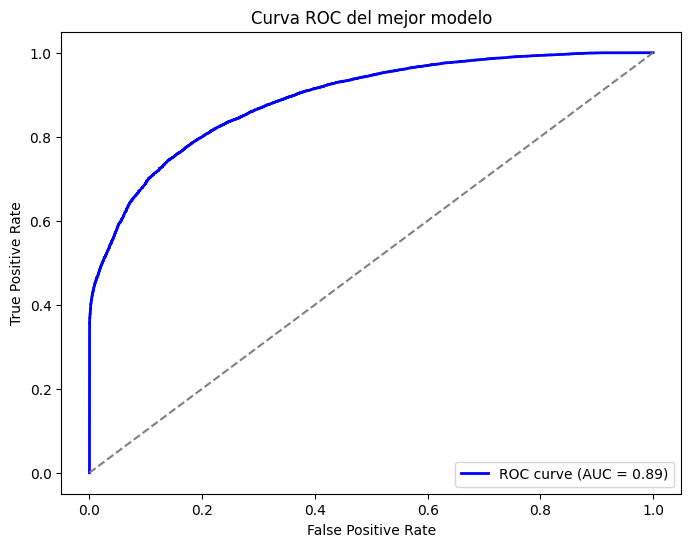

In [ ]:
# obtener el mejor modelo ya ajustado
best_model = grid_result.best_estimator_

# predicciones
y_pred_proba = best_model.predict_proba(X_test)[:,1]
y_pred = (y_pred_proba >= 0.5).astype(int)

# matriz de confusión
cm = confusion_matrix(y_test, y_pred)
print("Matriz de confusión:")
print(cm)

# classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC del mejor modelo')
plt.legend(loc="lower right")
plt.show()

“La búsqueda de grilla permitió optimizar la arquitectura con regularización, logrando un accuracy superior al 80% en validación cruzada. La métrica AUC confirma un buen poder discriminativo del modelo en test.”

## Del conjunto original (sin los valores excluidos) escoge al azar cinco observaciones en que “deposit_type_Non Refund” sea cero, y con esto realiza una predicción usando el mejor modelo encontrado por la búsqueda de grilla anterior. Comenta los resultados.

In [ ]:
df_orig = pd.read_csv('/content/hotel_bookings.csv')


In [ ]:
cols_to_drop = [
    'index',
    'arrival_date_year',
    'agent',
    'country',
    'company',
    'reservation_status',
    'reservation_status_date'
]
df_orig.drop(columns=cols_to_drop, inplace=True, errors='ignore')

In [ ]:
# verificar nulos
null_counts = df_orig.isnull().sum()
total_rows = df_orig.shape[0]
missing_percent = df_orig.isnull().any(axis=1).sum() / total_rows * 100

if missing_percent < 4:
    df_orig.dropna(inplace=True)
else:
    for col in df_orig.columns:
        if df_orig[col].isnull().sum() > 0:
            if df_orig[col].dtype == 'object':
                df_orig[col].fillna(df_orig[col].mode()[0], inplace=True)
            else:
                df_orig[col].fillna(df_orig[col].median(), inplace=True)

In [ ]:
df_dummies_orig = pd.get_dummies(df_orig, drop_first=True)

In [ ]:
print([col for col in df_dummies_orig.columns if "deposit_type" in col])

['deposit_type_Non Refund', 'deposit_type_Refundable']


In [ ]:
subset = df_dummies_orig[df_dummies_orig["deposit_type_Non Refund"] == 0]
sample_5 = subset.sample(5, random_state=42)

In [ ]:
X_sample = sample_5.drop("is_canceled", axis=1)
X_sample_scaled = scaler.transform(X_sample)

Predecir con el mejor modelo del grid

In [ ]:
y_sample_proba = grid_result.best_estimator_.predict_proba(X_sample_scaled)[:,1]
y_sample_pred = (y_sample_proba >= 0.5).astype(int)

# mostrar resultados
for i, (pred, prob) in enumerate(zip(y_sample_pred, y_sample_proba)):
    print(f"Reserva {i+1}: predicción {pred} (probabilidad {prob:.2f})")

Reserva 1: predicción 0 (probabilidad 0.00)
Reserva 2: predicción 0 (probabilidad 0.10)
Reserva 3: predicción 0 (probabilidad 0.15)
Reserva 4: predicción 1 (probabilidad 0.78)
Reserva 5: predicción 0 (probabilidad 0.32)


“En estas 5 reservas aleatorias con deposit_type_Non Refund igual a cero, el modelo predijo que 4 de ellas no se cancelarían, mientras que una presentó una probabilidad alta de cancelación (78%). Esto demuestra la capacidad del modelo para discriminar con un buen nivel de certeza, priorizando aquellas reservas más expuestas al riesgo de cancelación.”